# 1. Reading the results

We read the results from txt files into Pandas DataFrames for analysis.

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join


# Read all results from txt files

parameter_e_path = "./parameter_tuning/"
parameter_e_files = [f for f in listdir(parameter_e_path) if isfile(join(parameter_e_path, f))]

compare_path = "./compare/"
compare_files = [f for f in listdir(compare_path) if isfile(join(compare_path, f))]



# Parameter Setting (ACO & CLu): evaporation-factor/erasure-probability
column_names = ["Data-set", "Size", "Algorithm", "Support", "Run-time", "Cluster-time", "Patterns", "Pattern-count", "Misclustered-patterns", "Support-error", "E"]
df_pe = pd.DataFrame(columns = column_names)

for file in parameter_e_files:
    f_path = join(parameter_e_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    # mem = str(res['B'][1]) # memory
    alg = str(res['B'][1]) # algorithm
    att = int(res['B'][2]) # number of attributes in the data set
    size = int(res['B'][3])  # data set size
    evp = float(res['B'][4]) # evaporation-factor / erasure-probability
    # mit = int(res['B'][5]) # maximum iteraction count
    sup = float(res['B'][6]) # minimum support
    pat = int(res['B'][8]) # patterns        
    
    if alg == " Clu-GRAD (v1.9)":
        clu = float(res['B'][9][0:6]) # cluster-time
        
        # Fetch patterns to test accuracy
        miss = 0
        gps = [""] * pat
        errs = np.zeros(pat)  #[0.0] * pat
        gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            sups = str(res['B'][pos])
            gps[i] = [res['A'][pos], sups]
            sup_arr = sups.split(", ")
            est_sup = float(sup_arr[0])
            true_sup = float(sup_arr[1])
            if true_sup > 0:
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
            else:
                miss += 1
        # print(errs)
        error_rate = errs.mean()
    else:
        gps = [""] * pat
        gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            gps[i] = [res['A'][pos], float(res['B'][pos])]
        clu = 0
        miss = 0
        error_rate = 0
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    else:
        col = ""
        
    df_pe = df_pe.append({"Data-set": col, "Size": size, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp}, ignore_index=True)
df_pe['Algorithm'].replace({' Clu-GRAD (v1.9)' : 'CluGRAD'}, inplace=True)
df_pe['Algorithm'].replace({' ACO-GRAANK (v4.0)' : 'ACoGRAD'}, inplace=True)



# Comparison Experiment (ACO & CLu & GRA)
column_names = ["Data-set", "Size", "Algorithm", "Support", "Run-time", "Cluster-time", "Memory", "Patterns", "Pattern-count", "E"]
df_comp = pd.DataFrame(columns = column_names)
for file in compare_files:
    f_path = join(compare_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    mem = str(res['B'][1]) # memory
    alg = str(res['B'][2]) # algorithm
    att = int(res['B'][3]) # number of attributes in the data set
    size = int(res['B'][4])  # data set size

    if alg == " GRAANK ":
        evp = 0
        # mit = 0
        sup = float(res['B'][5]) # minimum support
        pat = int(res['B'][7]) # patterns
    else:
        evp = float(res['B'][5]) # evaporation-factor / erasure-probability
        # mit = int(res['B'][6]) # maximum iteraction count
    
        sup = float(res['B'][7]) # minimum support
        pat = int(res['B'][9]) # patterns
        
    if alg == " Clu-GRAD (v1.9)":
        clu = float(res['B'][10][0:6]) # cluster-time
    else:
        clu = 0
    
    # Fetch patterns
    gps = [""] * pat
    gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        gps[i] = [res['A'][pos], float(res['B'][pos])]
    
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 21:
        col = "DIR"
    else:
        col = ""
    df_comp = df_comp.append({"Data-set": col, "Size": size, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Memory":mem, "Patterns":gps, "Pattern-count":pat, "E": evp}, ignore_index=True)
df_comp['Algorithm'].replace({' Clu-GRAD (v1.9)' : 'CluGRAD'}, inplace=True)
df_comp['Algorithm'].replace({' ACO-GRAANK (v4.0)' : 'ACoGRAD'}, inplace=True)


# df_pe
df_comp

,Data-set,Size,Algorithm,Support,Run-time,Cluster-time,Memory,Patterns,Pattern-count,E
0,C2K,3942,GRAANK,0.5,589.000,0,"[83.18359375, 83.2265625, 1198.09765625, 1509...","[[['1+', '0+'] , 0.518], [['2-', '0+'] , 0.502...",600,0
1,DIR,15402,CluGRAD,0.5,1533.000,8.558,"[167.796875, 169.82421875, 1415.65234375, 224...","[[['12-', '13-'] , 0.871], [['2+', '7+', '14+'...",8,0.9
2,BCR,116,GRAANK,0.5,5.280,0,"[71.4296875, 71.4296875, 71.4296875, 71.42968...","[[['2+', '0+'] , 0.544], [['4+', '0+'] , 0.507...",58,0
3,BCR,116,ACoGRAD,0.5,0.083,0,"[103.1484375, 103.1484375, 103.1484375, 103.1...","[[['6-', '4+'] , 0.528], [['6-', '7+'] , 0.593...",4,0.5
4,C2K,3942,GRAANK,0.5,559.000,0,"[83.1875, 83.24609375, 1198.109375, 1509.1757...","[[['0+', '1+'] , 0.518], [['2-', '0+'] , 0.502...",600,0
5,C2K,3942,GRAANK,0.5,577.300,0,"[84.63671875, 84.6875, 1199.3515625, 1510.585...","[[['1+', '0+'] , 0.518], [['2-', '0+'] , 0.502...",600,0
6,C2K,3942,GRAANK,0.5,586.200,0,"[82.88671875, 82.90625, 1197.66015625, 1509.0...","[[['0+', '1+'] , 0.518], [['2-', '0+'] , 0.502...",600,0
7,AQY,9357,ACoGRAD,0.5,168.600,0,"[107.9609375, 107.91015625, 1222.86328125, 12...","[[['9+', '5+', '3+'] , 0.582], [['5+', '6+', '...",7,0.5
8,BCR,116,ACoGRAD,0.5,0.078,0,"[103.125, 103.125, 103.125, 103.125, 103.125,...","[[['6-', '8+'] , 0.575], [['4+', '3+', '8+'] ,...",2,0.5
9,C2K,3942,GRAANK,0.5,578.900,0,"[83.18359375, 83.2265625, 1198.10546875, 1509...","[[['0+', '1+'] , 0.518], [['2-', '0+'] , 0.502...",600,0


# 2. Parameter Setting

We conduct an analysis to determine:

* The optimum maximum-iteration for the ACO-GRAD algorithm and the optimum max-iteration for estimating score-vectors for the Clu-GRAD algorithm.

* The optimum values for evaporation-factor (ACO-GRAD) and erasure-probability (CLu-GRAD).


## 2.1 Parameter Setting (Maximum Iterations)


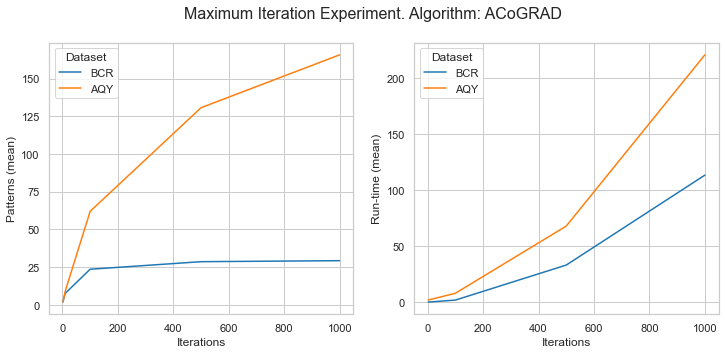

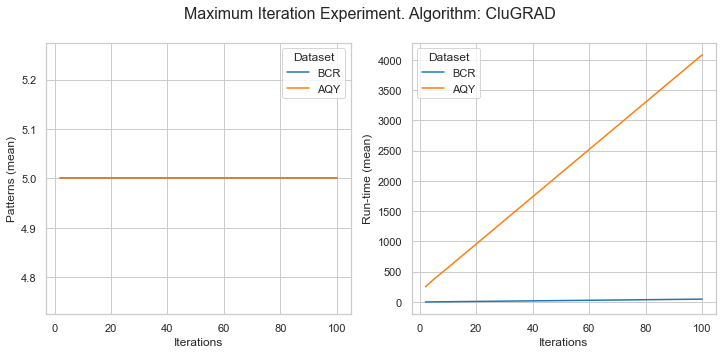

,Dataset,Algorithm,Iterations,Patterns (mean),Patterns (std),Run-time (mean),Run-time (std)
0,BCR,ACoGRAD,2,2.000000,0.000000,0.083333,0.013317
1,BCR,ACoGRAD,5,4.333333,0.577350,0.084333,0.002517
2,BCR,ACoGRAD,10,7.666667,0.577350,0.102333,0.001528
3,BCR,ACoGRAD,100,23.666667,1.154701,1.745333,0.224179
4,BCR,ACoGRAD,500,28.666667,0.577350,33.053333,0.677225
5,BCR,ACoGRAD,1000,29.333333,1.154701,113.433333,10.600629
6,BCR,CluGRAD,2,5.000000,0.000000,1.586333,0.017926
7,BCR,CluGRAD,5,5.000000,0.000000,3.023000,0.030512
8,BCR,CluGRAD,10,5.000000,0.000000,5.385000,0.137022
9,BCR,CluGRAD,100,5.000000,0.000000,47.940000,1.075546


In [49]:
import numpy as np

# data_sets = ['BCR', 'DIR', 'C2K', 'AQY', 'HPC']
data_sets = ['BCR', 'AQY']
algorithms = ['ACoGRAD', 'CluGRAD'] #, 'GRAANK']
evals_it = [2, 5, 10, 100, 500, 1000]
evals_e = [0.25, 0.5, 0.75, 0.9]

eval_data_iter = []
eval_data_e = []


# Only include these columns
df_res = df_piter[["Data-set", "Algorithm", "Support", "Run-time", "Pattern-count", "Max-iteration", "Patterns", 'E']]

for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]

    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        # print(df1)
        for ev in evals_it:
            df3 = df2.loc[df2['Max-iteration'] == ev]
            if not df3.empty:
                # print(df2)
                pat_arr = []
                for index,row in df3.iterrows():
                    # 10/100/1000 evaluations
                    pat_arr.append(row['Patterns'])
                    # print(pat_arr)
                eval_data_iter.append([ds, alg, ev, df3['Pattern-count'].mean(), df3['Pattern-count'].std(), df3['Run-time'].mean(), df3['Run-time'].std()])
                       
df_data_1 = pd.DataFrame(data=eval_data_iter, columns=['Dataset', 'Algorithm', 'Iterations', 'Patterns (mean)', 'Patterns (std)', 'Run-time (mean)', 'Run-time (std)'])

# Plotting the results 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

for alg in algorithms:
    df1 = df_data_1.loc[df_data_1['Algorithm'] == alg]
    
    fig = plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df1, x="Iterations", y="Patterns (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df1, x="Iterations", y="Run-time (mean)", hue="Dataset", palette="tab10")  # markers=True)
    
    fig.suptitle('Maximum Iteration Experiment. Algorithm: ' + alg, fontsize=16)
plt.show()
df_data_1

## 2.2 Parameter Setting (Evaporation Factor/Erasure Probability)



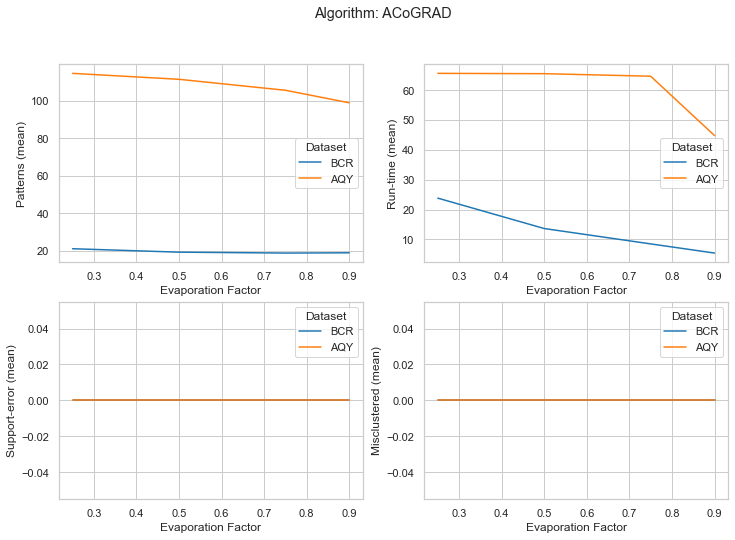

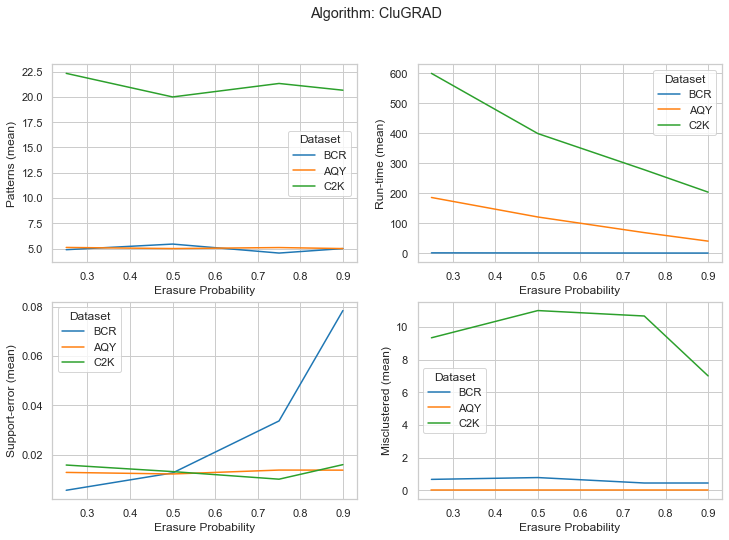

,Dataset,Algorithm,EFactor/ EProbability,Patterns (mean),Patterns (std),Misclustered (mean),Misclustered (std),Support-error (mean),Support-error (std),Run-time (mean),Run-time (std)
0,BCR,ACoGRAD,0.25,21.166667,1.722401,0.000000,0.000000,0.000000,0.000000,23.836667,6.607325
1,BCR,ACoGRAD,0.50,19.333333,1.505545,0.000000,0.000000,0.000000,0.000000,13.648500,4.351064
2,BCR,ACoGRAD,0.75,18.857143,1.345185,0.000000,0.000000,0.000000,0.000000,8.500000,1.584887
3,BCR,ACoGRAD,0.90,19.000000,1.732051,0.000000,0.000000,0.000000,0.000000,5.429778,0.812165
4,BCR,CluGRAD,0.25,4.888889,0.600925,0.666667,0.500000,0.005515,0.002672,1.150000,0.073651
5,BCR,CluGRAD,0.50,5.444444,1.589899,0.777778,0.440959,0.012543,0.004378,0.831000,0.075040
6,BCR,CluGRAD,0.75,4.555556,1.509231,0.444444,0.527046,0.033632,0.012027,0.556222,0.053993
7,BCR,CluGRAD,0.90,5.000000,1.322876,0.444444,0.527046,0.078375,0.014947,0.457667,0.042152
8,AQY,ACoGRAD,0.25,114.500000,3.109126,0.000000,0.000000,0.000000,0.000000,65.647500,0.460172
9,AQY,ACoGRAD,0.50,111.333333,6.250333,0.000000,0.000000,0.000000,0.000000,65.536667,1.834608


In [86]:
import numpy as np

# data_sets = ['BCR', 'DIR', 'C2K', 'AQY', 'HPC']
data_sets = ['BCR', 'AQY', 'C2K']
algorithms = ['ACoGRAD', 'CluGRAD']#, 'GRAANK']
evals_it = [2, 5, 10, 100, 500, 1000]
evals_e = [0.25, 0.5, 0.75, 0.9]

eval_data_iter = []
eval_data_e = []


# Only include these columns
df_res = df_pe[["Data-set", "Algorithm", "Support", "Run-time", "Pattern-count", "Misclustered-patterns", "Support-error", "Max-iteration", "Patterns", 'E']]

for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]

    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        # print(df1)
        for ev in evals_e:
            df3 = df2.loc[df2['E'] == ev]
            if not df3.empty:
                # print(df2)
                pat_arr = []
                for index,row in df3.iterrows():
                    # 10/100/1000 evaluations
                    pat_arr.append(row['Patterns'])
                    # print(pat_arr)
                eval_data_e.append([ds, alg, ev, df3['Pattern-count'].mean(), df3['Pattern-count'].std(), df3['Misclustered-patterns'].mean(), df3['Misclustered-patterns'].std(), df3['Support-error'].mean(), df3['Support-error'].std(), df3['Run-time'].mean(), df3['Run-time'].std()])
                       
df_data_2 = pd.DataFrame(data=eval_data_e, columns=['Dataset', 'Algorithm', 'EFactor/ EProbability', 'Patterns (mean)', 'Patterns (std)', 'Misclustered (mean)', 'Misclustered (std)', 'Support-error (mean)', 'Support-error (std)', 'Run-time (mean)', 'Run-time (std)'])

# Plotting the results 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

for alg in algorithms:
    df1 = df_data_2.loc[df_data_2['Algorithm'] == alg]
    
    if alg == 'ACoGRAD':
        x_label = "Evaporation Factor"
    elif alg == 'CluGRAD':
        x_label = "Erasure Probability"
    
    fig = plt.figure(figsize=(12,8))
    plt.subplot(2, 2, 1)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Patterns (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    plt.subplot(2, 2, 2)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Run-time (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    
    plt.subplot(2, 2, 3)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Support-error (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    
    plt.subplot(2, 2, 4)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Misclustered (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)

    fig.suptitle('Algorithm: ' + alg)
plt.show()
df_data_2


# 3. Comparison of Algorithms

We run an experiment that analyses the computational performance of ACO-GRAD, Clu-GRAD and GRAANK on the 4 data sets.